# GTHA housing market database
# OSEMN methodology Step 4: Model
# Predict land use from new features in Teranet
# Feature Selection with NaN filled

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
random_state = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE, RFECV,\
                                      chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model, SBS, fit_sbs

In [4]:
def fit_rfecv(classifier, X, y, model_name,
              step=1, kfold=2, fig_width=6, fig_height=4):
    t = time()

    rfecv = RFECV(estimator=classifier, step=step, cv=StratifiedKFold(kfold),
                  scoring='accuracy')
    rfecv.fit(X, y)

    print("{0} fit using RFE".format(model_name))
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    f, ax = plt.subplots(1, figsize=(fig_width, fig_height))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    ax.set_title(model_name + '\nRecursive Feature Elimination (RFE) with cross-validation')
    plt.show()

    elapsed = time() - t
    print("RFE fit, took, {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

In [5]:
def fit_sbs(classifier, k_features, X, y, y_min=None, y_max=None, height=4, width=6,
            title="SBS", output='show', save_path='sbs.png', return_feats=True):
    t = time()

    sbs = SBS(classifier, k_features=k_features)

    sbs.fit(X, y)

    elapsed = time() - t
    print("Sequential Backwards Selection algorithm was applied. Took {0:,.2f} seconds, ({1:,.2f} minutes)."
          .format(elapsed, elapsed / 60))

    k_feat = [len(k) for k in sbs.subsets_]

    f, ax = plt.subplots(1, figsize=(width, height))
    plt.plot(k_feat, sbs.scores_, marker='o')
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    if output == 'show':
        plt.show()
    elif output == 'save':
        f.savefig(save_path, dpi=300, bbox_inches='tight')
    if return_feats:
        return sbs.subsets_

## Load Teranet data

In [6]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '4_Teranet_lu_predict.zip',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [7]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 96.27 seconds
with 5,188,513 rows
and 81 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change

## Load Census data

In [8]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [9]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.16 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [10]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [11]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [12]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 46.04 seconds (0.77 minutes)
with 5,188,513 rows
and 111 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=111)


## Join TTS data to Teranet data

In [13]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 60.51 seconds (1.01 minutes)
with 5,188,513 rows
and 117 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)


## Take a train-test subset of Teranet records

In [14]:
year_train_test = 2012
year_val1 = 2011
year_val2 = 2013

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

205,341 Teranet records in the train-test subset (records from 2012).
219,130 Teranet records in the validation subset #1 (records from 2011).
207,686 Teranet records in the validation subset #2 (records from 2013).


## Select features

In [15]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)

In [16]:
all_feat_cols = ['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
                 'xy_first_sale', 'pin_years_since_last_sale',
                 'xy_years_since_last_sale', 'xy_years_to_next_sale',
                 'da_days_since_last_sale', 'da_years_since_last_sale',
                 'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
                 'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
                 'price_da_pct_change', 'med_price_xy', 'med_price_year',
                 'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
                 'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
                 'outlier_xy_10', 
                 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
                 'Avg_val_dwel', 'Avg_rent', 'Pop_x', 'PopDens', 'Dwel', 'DwelDens',
                 'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
                 'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
                 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
                 'Usl_wkpl', 'Blue_cljob', 'White_cljob',
                 'Pop_y', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars',
                 'lucr_detached', 'lucr_duplex_townhouse', 'lucr', 'lucr_condo', 'lucr_other']
s = s[all_feat_cols]
s_val1 = s_val1[all_feat_cols]
s_val2 = s_val2[all_feat_cols]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 69 columns):
pin_total_sales              205341 non-null int64
xy_total_sales               205341 non-null int64
pin_prev_sales               205341 non-null int64
xy_prev_sales                205341 non-null int64
xy_first_sale                205341 non-null bool
pin_years_since_last_sale    138498 non-null float64
xy_years_since_last_sale     176503 non-null float64
xy_years_to_next_sale        137302 non-null float64
da_days_since_last_sale      205341 non-null float64
da_years_since_last_sale     205341 non-null float64
xy_sale_next_6m              205341 non-null bool
price_2016                   205341 non-null float64
pin_price_cum_sum            205341 non-null float64
xy_price_cum_sum             205341 non-null float64
pin_price_pct_change         138330 non-null float64
xy_price_pct_change          176349 non-null float64
price_da_pct_change          205340 non-null float64
me

In [17]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s.loc[mask1, col2].mean(), s.loc[mask1, col2].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.59, median=5.89


In [18]:
col1 = 'xy_years_since_last_sale'
col2 = 'xy_years_to_next_sale'
mask1 = s[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s.loc[mask1, col2].mean(), s.loc[mask1, col2].median()))

For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.07, median=1.72


In [19]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'

# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s[col1].isnull()
s.loc[mask1, col1] = s.loc[mask1, col2].median()
mask1 = s_val1[col1].isnull()
s_val1.loc[mask1, col1] = s_val1.loc[mask1, col2].median()
mask1 = s_val2[col1].isnull()
s_val2.loc[mask1, col1] = s_val2.loc[mask1, col2].median()

mask1 = s[col2].isnull()
s.loc[mask1, col2] = s.loc[mask1, col1].median()
mask1 = s_val1[col2].isnull()
s_val1.loc[mask1, col2] = s_val1.loc[mask1, col1].median()
mask1 = s_val2[col2].isnull()
s_val2.loc[mask1, col2] = s_val2.loc[mask1, col1].median()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 69 columns):
pin_total_sales              205341 non-null int64
xy_total_sales               205341 non-null int64
pin_prev_sales               205341 non-null int64
xy_prev_sales                205341 non-null int64
xy_first_sale                205341 non-null bool
pin_years_since_last_sale    138498 non-null float64
xy_years_since_last_sale     205341 non-null float64
xy_years_to_next_sale        205341 non-null float64
da_days_since_last_sale      205341 non-null float64
da_years_since_last_sale     205341 non-null float64
xy_sale_next_6m              205341 non-null bool
price_2016                   205341 non-null float64
pin_price_cum_sum            205341 non-null float64
xy_price_cum_sum             205341 non-null float64
pin_price_pct_change         138330 non-null float64
xy_price_pct_change          176349 non-null float64
price_da_pct_change          205340 non-null float64
me

In [20]:
target_cols = 5
feat_cols = s.columns[:-target_cols]
drop_cols = ['pin_price_pct_change', 'pin_price_pct_change', 'xy_price_pct_change', 'pin_years_since_last_sale']
mask1 = feat_cols.isin(drop_cols)
feat_cols = feat_cols[~mask1]
feat_target_cols = \
    feat_cols.append(pd.Index(['lucr_detached', 'lucr_duplex_townhouse', 'lucr', 'lucr_condo', 'lucr_other']))
s = s[feat_target_cols]
s_val1 = s_val1[feat_target_cols]
s_val2 = s_val2[feat_target_cols]
print("Rows with missing values were dropped.")

Rows with missing values were dropped.


In [21]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

202,979 rows in train-test subset, 213,823 rows in validation subset #1, 203,473 rows in validation subset #2


## Encode target

In [22]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

s['lucr_detached_e'] = le.fit_transform(s['lucr_detached'])
s_val1['lucr_detached_e'] = le.transform(s_val1['lucr_detached'])
s_val2['lucr_detached_e'] = le.transform(s_val2['lucr_detached'])

s['lucr_duplex_townhouse_e'] = le.fit_transform(s['lucr_duplex_townhouse'])
s_val1['lucr_duplex_townhouse_e'] = le.transform(s_val1['lucr_duplex_townhouse'])
s_val2['lucr_duplex_townhouse_e'] = le.transform(s_val2['lucr_duplex_townhouse'])

s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s_val1['lucr_condo_e'] = le.transform(s_val1['lucr_condo'])
s_val2['lucr_condo_e'] = le.transform(s_val2['lucr_condo'])

s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s_val1['lucr_other_e'] = le.transform(s_val1['lucr_other'])
s_val2['lucr_other_e'] = le.transform(s_val2['lucr_other'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val1 = s_val1.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val2 = s_val2.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels_list = ['condo', 'detached', 'duplex_townhouse', 'other']

condo               55501
detached            59349
duplex_townhouse    13200
other               74929
Name: lucr, dtype: int64
0    55501
1    59349
2    13200
3    74929
Name: lucr_e, dtype: int64
condo               62618
detached            60038
duplex_townhouse    13650
other               77517
Name: lucr, dtype: int64
0    62618
1    60038
2    13650
3    77517
Name: lucr_e, dtype: int64
condo               48257
detached            56741
duplex_townhouse    12481
other               85994
Name: lucr, dtype: int64
0    48257
1    56741
2    12481
3    85994
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

#### Select features and target

In [23]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [55501 59349 13200 74929]
Labels counts in y_train: [38851 41544  9240 52450]
Labels counts in y_test: [16650 17805  3960 22479]
Labels counts in y_val1: [62618 60038 13650 77517]
Labels counts in y_val2: [48257 56741 12481 85994]


#### Standardize features

In [25]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [26]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


## Feature selection based on Variance Treshold

[`VarianceThreshold`](https://scikit-learn.org/stable/modules/feature_selection.html) in `scikit-learn` is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold.

### Boolean features
Boolean features are Bernoulli random variables, and the variance of such variables is given by:

$Var[X] = p(1 - p)$

In [27]:
def vt_bernoulli_selector(df, p=0.0):
    """
    This function tests features as Bernoulli variables
    for minimum variance using VarianceThreshold

    Boolean features are Bernoulli random variables, 
    and the variance of such variables is given by:
    
    Var[X] = p(1 - p)
    """
    selector = VarianceThreshold(threshold=(p * (1 - p)))
    selector.fit(df)
    new_feats = df.columns[selector.get_support(indices=True)]
    print("----- Originally, {0} boolean features:\n\n".format(df.shape[1]), df.columns)
    print("\n----- Using Variance Threshold with p={0}, {1} boolean features:\n\n{2}\n\n{3} have been filtered out"
          .format(p, len(new_feats), new_feats, df.columns.difference(new_feats)))

#### Check variance of Boolean features

In [28]:
mask1 = s[feat_cols].dtypes == 'bool'
bool_cols = s[feat_cols].columns[mask1]
print("{0} features have Boolean data type.".format(len(bool_cols)))
s_bool = s[bool_cols]
s_bool.columns

9 features have Boolean data type.


Index(['xy_first_sale', 'xy_sale_next_6m', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10'],
      dtype='object')

In [29]:
s_bool.var().sort_values()

outlier_xy_10      0.003975
outlier_y_20       0.005643
outlier_xy_4       0.005663
outlier_y_10       0.008034
outlier_y_5        0.016808
outlier_xy_2       0.022553
outlier_y_3        0.039495
xy_first_sale      0.120833
xy_sale_next_6m    0.250000
dtype: float64

#### Filter out features with no variance

In [30]:
vt_bernoulli_selector(s_bool)

----- Originally, 9 boolean features:

 Index(['xy_first_sale', 'xy_sale_next_6m', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10'],
      dtype='object')

----- Using Variance Threshold with p=0.0, 9 boolean features:

Index(['xy_first_sale', 'xy_sale_next_6m', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10'],
      dtype='object')

Index([], dtype='object') have been filtered out


#### Filter out features with low variance
Removing all features that have the same value more than 99% of the time.

In [31]:
vt_bernoulli_selector(s_bool, p=0.9)

----- Originally, 9 boolean features:

 Index(['xy_first_sale', 'xy_sale_next_6m', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10'],
      dtype='object')

----- Using Variance Threshold with p=0.9, 2 boolean features:

Index(['xy_first_sale', 'xy_sale_next_6m'], dtype='object')

Index(['outlier_xy_10', 'outlier_xy_2', 'outlier_xy_4', 'outlier_y_10',
       'outlier_y_20', 'outlier_y_3', 'outlier_y_5'],
      dtype='object') have been filtered out


## Tree-based feature selection from model

In [73]:
feat_df = pd.DataFrame(feat_cols).rename(columns={0: 'var'})
print("Feature DataFrame initiated, {0} features in total.".format(len(feat_df)))

Feature DataFrame initiated, 61 features in total.


### Extra Trees Classifier

In [33]:
t = time()
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
elapsed = time() - t
print("{0} features selected from model, took {1:,.2f} seconds ({2:,.2f} minutes)."
      .format(model.get_support().sum(), elapsed, elapsed / 60) + "\n")
etrees_feats = s.columns[model.get_support(indices=True)]
etrees_feats

16 features selected from model, took 17.27 seconds (0.29 minutes).



Index(['xy_total_sales', 'pin_prev_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_sale_next_6m',
       'xy_price_cum_sum', 'med_price_xy', 'Avg_HHsize', 'PopDens', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'CarTrVan_d'],
      dtype='object')

In [74]:
subset_name = 'etrees'
sel_feats_df = pd.DataFrame(etrees_feats).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    45
True     16
Name: etrees, dtype: int64

### Random Forest Classifier

In [35]:
n_trees = 16
clf = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=random_state, n_jobs=8)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)

print("{0} features selected from model".format(model.get_support().sum()) + "\n")
forest_feats = s.columns[model.get_support(indices=True)]
forest_feats

21 features selected from model



Index(['xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'pin_price_cum_sum', 'xy_price_cum_sum', 'med_price_xy', 'Avg_own_payt',
       'Avg_val_dwel', 'PopDens', 'Dwel', 'DwelDens', 'Sgl_det', 'Apt_5plus',
       'Sgl_att', 'CarTrVan_d', 'Not_lbrfrc', 'Cars'],
      dtype='object')

In [75]:
subset_name = 'forest'
sel_feats_df = pd.DataFrame(forest_feats).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    40
True     21
Name: forest, dtype: int64

Possible number of feature combinations
$ \large{ _nC_k = \binom{n} {k} = \frac{n!} {k!(n - k)!} } $

In [37]:
from math import factorial as fact

n = len(feat_cols)
k = len(forest_feats)
nCk = fact(n) / (fact(k) * fact(n - k))
print("Possible number of ways to select {0} features out of {1}: {2:,.0f}.".format(len(forest_feats), len(feat_cols), nCk))

Possible number of ways to select 21 features out of 61: 12,176,310,231,149,296.


In [64]:
print('{0:,}'.format(10 ** 16))

10,000,000,000,000,000


## Univariate feature selection: Select k Best (k=19)
Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. `SelectKBest` removes all but the $k$ highest scoring features based on the result of the selected statistical test.

### $\chi^2$ test

In [39]:
# Pearson's chi-2 test requires features to be non-negative
sc = MinMaxScaler()
X_norm = sc.fit_transform(X)

selector_name = 'Select k Best, k={0}, chi-2 test'.format(k)
selector = SelectKBest(chi2, k=k)
selector.fit(X_norm, y)
print(selector_name)
kbest_chi2 = s.columns[selector.get_support(indices=True)]
kbest_chi2

Select k Best, k=21, chi-2 test


Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_sale_next_6m',
       'outlier_y_3', 'outlier_y_10', 'Avg_HHsize', 'Avg_rent', 'PopDens',
       'Dwel', 'DwelDens', 'Sgl_det', 'Apt_5plus', 'Rented', 'PT', 'Walk',
       'Not_lbrfrc', 'White_cljob', 'Jobs'],
      dtype='object')

In [76]:
subset_name = 'kbest_chi-2'
sel_feats_df = pd.DataFrame(kbest_chi2).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    40
True     21
Name: kbest_chi-2, dtype: int64

### ANOVA f-value test

In [41]:
selector_name = 'Select k Best, k={0}, ANOVA f-value test'.format(k)
selector = SelectKBest(f_classif, k=k)
selector.fit(X, y)
print(selector_name)
kbest_anova = s.columns[selector.get_support(indices=True)]
kbest_anova

Select k Best, k=21, ANOVA f-value test


Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'Avg_HHsize', 'Avg_rent', 'PopDens', 'Dwel',
       'DwelDens', 'Sgl_det', 'Apt_5plus', 'Rented', 'PT', 'Walk',
       'Not_lbrfrc', 'White_cljob', 'Jobs'],
      dtype='object')

In [77]:
subset_name = 'kbest_anova'
sel_feats_df = pd.DataFrame(kbest_anova).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    40
True     21
Name: kbest_anova, dtype: int64

### Mutual information test

In [43]:
selector_name = 'Select k Best, k={0}, mutual information test'.format(k)
t = time()
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
elapsed = time() - t
print(selector_name + ", took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
kbest_mit = s.columns[selector.get_support(indices=True)]
kbest_mit

Select k Best, k=21, mutual information test, took 251.68 seconds (4.19 minutes)


Index(['xy_total_sales', 'xy_prev_sales', 'xy_years_since_last_sale',
       'xy_price_cum_sum', 'med_price_xy', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop_x', 'PopDens', 'Dwel', 'DwelDens',
       'Lbrfrc', 'White_cljob', 'Pop_y', 'FT_wrk', 'Stu', 'HH', 'Jobs',
       'Cars'],
      dtype='object')

In [78]:
subset_name = 'kbest_mit'
sel_feats_df = pd.DataFrame(kbest_mit).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    40
True     21
Name: kbest_mit, dtype: int64

## Recursive Feature Elimination (RFE) algorithm from `scikit-learn`
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFECV performs RFE in a cross-validation loop to find the optimal number of features.

### RFE with Perceptron

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

Perceptron, eta=0.22 fit using RFE
Optimal number of features : 4


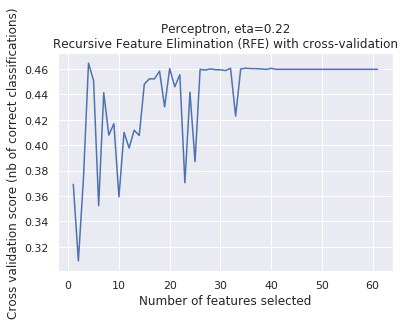

RFE fit, took, 397.96 seconds (6.63 minutes)


In [45]:
eta = 0.22
model_name = "Perceptron, eta={0}".format(eta)
ppn = Perceptron(max_iter=100, eta0=eta, random_state=random_state)
fit_rfecv(ppn, X, y, model_name)

### RFE with Decision Tree

Decision Tree (raw features, gini criterion, max_depth=16) fit using RFE
Optimal number of features : 56


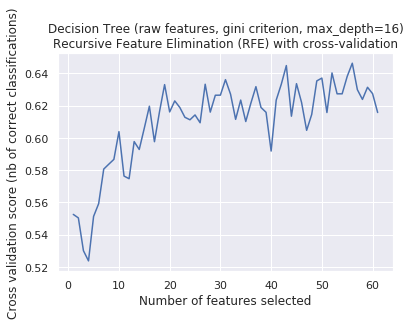

RFE fit, took, 297.75 seconds (4.96 minutes)


In [46]:
max_depth = 16
criterion = 'gini'
model_name = 'Decision Tree (raw features, {0} criterion, max_depth={1})'.format(criterion, max_depth)
tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=random_state)
fit_rfecv(tree, X, y, model_name)

### RFE with Random Forest

Random Forest (raw features, gini criterion, n_estimators=16) fit using RFE
Optimal number of features : 49


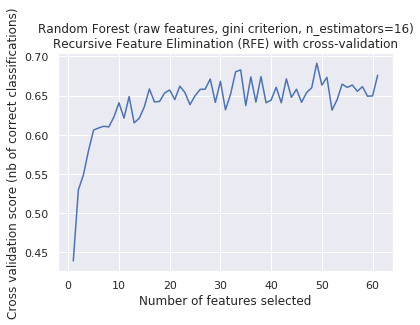

RFE fit, took, 238.22 seconds (3.97 minutes)


In [47]:
n_trees = 16
criterion = 'gini'
model_name = 'Random Forest (raw features, {0} criterion, n_estimators={1})'.format(criterion, n_trees)
forest = RandomForestClassifier(criterion=criterion, n_estimators=n_trees, random_state=1, n_jobs=8)
fit_rfecv(forest, X, y, model_name)

## Sequential Backwards Selection (SBS) algorithm

In [65]:
teranet_subset_name = '2012fillna'

### SBS with Perceptron

Sequential Backwards Selection algorithm was applied. Took 882.33 seconds, (14.71 minutes).


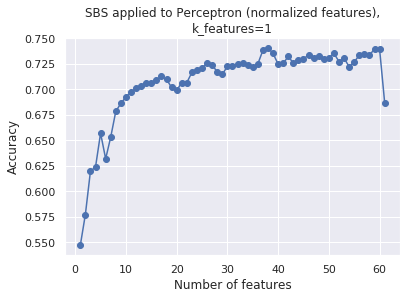

In [49]:
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1, n_jobs=8)
k_features = 1
model_name = "Perceptron (normalized features)"
save_name = 'ppn'
ppn_feats = fit_sbs(ppn, k_features, X_train_norm, y_train, output='save', 
            save_path='../../results/plots/sbs_{0}_{1}_kfeats_{2}.png'.format(subset_name, save_name, k_features),
            title="SBS applied to {0},\nk_features={1}".format(model_name, k_features))

#### Best features

In [50]:
sbs_ppn_k = feat_cols[list(ppn_feats[-k])]
sbs_ppn_k

Index(['pin_total_sales', 'xy_total_sales', 'xy_first_sale',
       'xy_years_to_next_sale', 'da_days_since_last_sale', 'price_2016',
       'pin_price_cum_sum', 'med_price_xy', 'price_to_med_year',
       'outlier_y_10', 'Avg_HHinc', 'Pop_x', 'PopDens', 'Sgl_det',
       'CarTrVan_p', 'Walk', 'Lbrfrc', 'Not_lbrfrc', 'Pop_y', 'FT_wrk',
       'Jobs'],
      dtype='object')

In [79]:
subset_name = 'sbs_ppn'
sel_feats_df = pd.DataFrame(sbs_ppn_k).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    40
True     21
Name: sbs_ppn, dtype: int64

### SBS with Random Forest

Sequential Backwards Selection algorithm was applied. Took 4,338.86 seconds, (72.31 minutes).


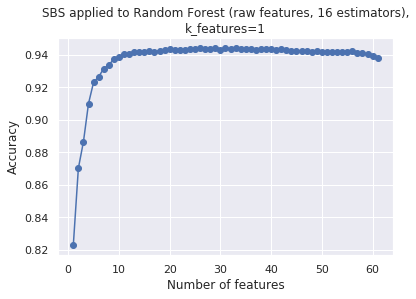

In [52]:
k_features = 1
n_trees = 16
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=12)
model_name = 'Random Forest (raw features, {0} estimators)'.format(n_trees)
save_name = 'forest{0}'.format(n_trees)
rf_feats = fit_sbs(forest, k_features, X_train, y_train, output='save', 
                   save_path='../../results/plots/sbs_{0}_{1}_kfeats_{2}.png'.format(subset_name, save_name, k_features),
                   title="SBS applied to {0},\nk_features={1}".format(model_name, k_features))

#### Best features

In [80]:
sbs_forest_k = feat_cols[list(rf_feats[-k])]
sbs_forest_k

Index(['xy_total_sales', 'xy_prev_sales', 'xy_years_since_last_sale',
       'price_2016', 'xy_price_cum_sum', 'med_price_xy', 'price_to_med_year',
       'outlier_y_20', 'Avg_HHinc', 'Avg_own_payt', 'Avg_val_dwel', 'Avg_rent',
       'Pop_x', 'PopDens', 'Sgl_det', 'Sgl_att', 'CarTrVan_d', 'Lbrfrc', 'Stu',
       'HH', 'Jobs'],
      dtype='object')

In [81]:
sbs_forest_10 = feat_cols[list(rf_feats[-10])]
sbs_forest_10

Index(['xy_prev_sales', 'xy_years_since_last_sale', 'med_price_xy',
       'price_to_med_year', 'Avg_own_payt', 'Avg_val_dwel', 'PopDens',
       'Sgl_det', 'CarTrVan_d', 'HH'],
      dtype='object')

In [82]:
subset_name = 'sbs_forest'
sel_feats_df = pd.DataFrame(sbs_forest_k).rename(columns={0: 'var'})
sel_feats_df[subset_name] = True

feat_df = pd.merge(feat_df, sel_feats_df, how='left')
feat_df[subset_name] = feat_df[subset_name].fillna(False)
feat_df[subset_name].value_counts()

False    40
True     21
Name: sbs_forest, dtype: int64

## Summarize feature importance

In [83]:
feat_df = feat_df.set_index('var')

In [84]:
min_selections = 4
mask1 = feat_df.sum(axis=1) >= 4
top_feats = feat_cols[mask1]
print("{0} features that were selected by at least {1} different methods:\n".format(len(top_feats), min_selections))
top_feats

15 features that were selected by at least 4 different methods:



Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_price_cum_sum',
       'med_price_xy', 'Avg_rent', 'PopDens', 'Dwel', 'DwelDens', 'Sgl_det',
       'Apt_5plus', 'Not_lbrfrc', 'Jobs'],
      dtype='object')

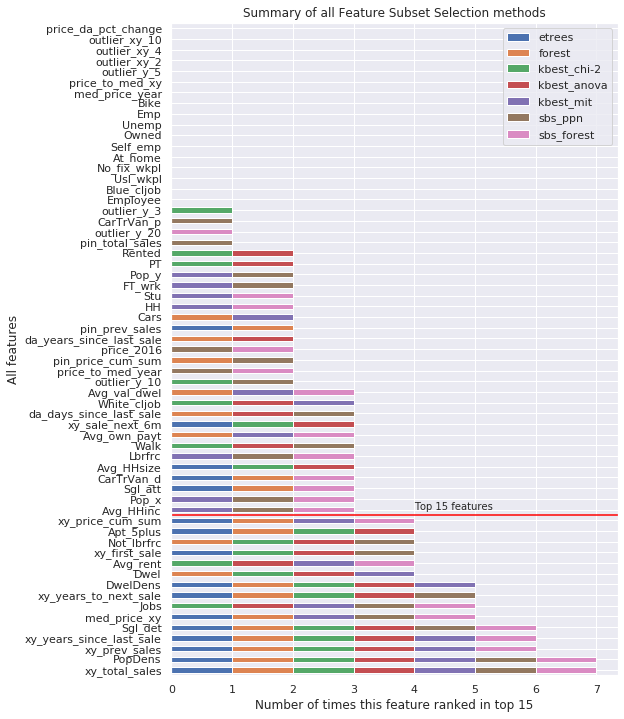

In [85]:
highlight_top = len(top_feats)

idx_order = feat_df.sum(axis=1).sort_values(ascending=False).index

f, ax = plt.subplots(1, figsize=(8, 12))

feat_df.loc[idx_order].astype('int').plot(kind='barh', stacked=True, ax=ax)

ax.set_title("Summary of all Feature Subset Selection methods")
ax.set_ylabel("All features")
ax.set_xlabel("Number of times this feature ranked in top {0}".format(highlight_top))
ax.axhline(highlight_top - 0.5, color='red')
ax.text(4, highlight_top, "Top {0} features".format(highlight_top))
plt.savefig('../../results/plots/feature_selection_summary_{0}_kfeats_{1}.png'.format(teranet_subset_name, k), 
            dpi=300)

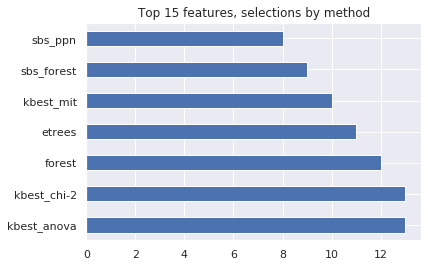

In [86]:
feat_df.loc[top_feats].sum().sort_values(ascending=False).plot(kind='barh', 
                                        title='Top {0} features, selections by method'.format(len(top_feats)));

## Top selected features

In [87]:
top15f = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_price_cum_sum',
          'med_price_xy', 'Avg_rent', 'PopDens', 'Dwel', 'DwelDens', 'Sgl_det',
          'Apt_5plus', 'Not_lbrfrc', 'Jobs']

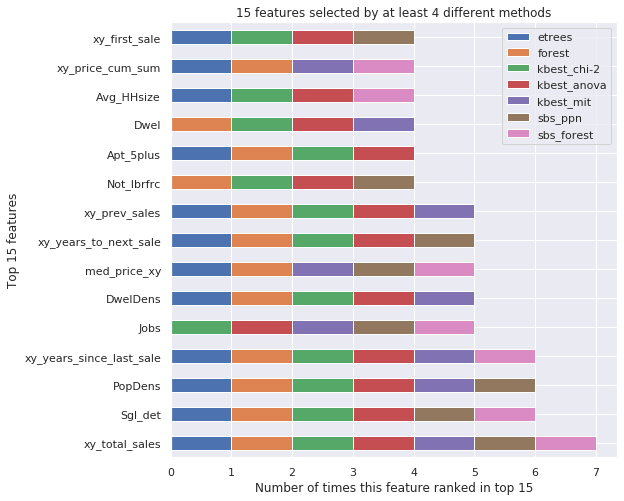

In [68]:
idx_order = feat_df.loc[top15f].sum(axis=1).sort_values(ascending=False).index
f, ax = plt.subplots(1, figsize=(8, 8))

feat_df.loc[idx_order].astype('int').plot(kind='barh', stacked=True, ax=ax)

ax.set_title("{0} features selected by at least {1} different methods".format(len(top_feats), min_selections))
ax.set_ylabel("Top {0} features".format(len(top_feats)))
ax.set_xlabel("Number of times this feature ranked in top {0}".format(highlight_top))
plt.savefig('../../results/plots/feature_selection_summary_{0}_kfeats_{1}_top.png'.format(teranet_subset_name, k), dpi=300)